In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID december 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
file_used = 'productionfile.csv'

time_period = 1800 #seconds

In [3]:
sys.path[0]

''

In [4]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


### Export for simulator file and visualise

In [5]:
def add_breaks(production):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    maxtime = 7200
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE'})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [6]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:30])]
df_task = add_breaks(df_task)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName
0,50703,2016-01-25 18:16:20.717,2016-01-25 18:18:26.000,126.000,10,"SPIRALEN DURUM AS 1,1%"
1,50703,2016-01-25 18:18:26.000,2016-01-26 01:26:52.847,25706.000,100,"SPIRALEN DURUM AS 1,1%"
2,50703,2016-01-26 01:26:52.847,2016-01-26 01:33:33.140,401.000,10,"SPIRALEN DURUM AS 1,1%"
3,-1,2016-01-26 01:33:33.140,2016-01-26 01:33:37.847,4.707,0,NONE
4,50741,2016-01-26 01:33:37.847,2016-01-26 01:39:45.923,368.000,1,HORENTJE H/Z 10/90


In [7]:
df_task.ProductionRequestId.unique()

array([50703.0, -1, 50741.0, -2, 50912.0, -3, 50913.0, -4, 50877.0, -5,
       50926.0, -6, 50925.0, -7, 51037.0, -8, 51036.0, -9, 51099.0, -10,
       50676.0, -11, -12, -13, -14, 51098.0, -15, -16, -17, -18, -19, -20,
       -21, -22, 51166.0, -23, 50831.0, -24, -25, -26, -27, -28, -29, -30,
       -31, -32, -33, -34, -35, 51216.0, -36, 51215.0, -37, 51209.0, -38,
       51210.0, -39, 51214.0, -40, 51213.0], dtype=object)

In [8]:
prodtime = df_task.Duration[df_task.ArticleName != 'NONE'].sum() / 3600
print('Production time', prodtime)
idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600
print('Idle time', idletime)

Production time 148.90305555555557
Idle time 47.39240416666667


In [9]:
def plot_gantt(df_task, reason_str, articlename, startdate='StartDateUTC', enddate='EndDateUTC'):
    df_task['Start'] = (df_task[startdate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600
    df_task['End'] = (df_task[enddate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600
    # Plot a line for every line of data in your file
    from cycler import cycler
    cy = cycler(color=['b','g','orange','c','m','yellow','steelblue', 'tan',
                                              'lawngreen', 'cyan', 'darkorange', 'crimson', 'greenyellow', 'darkviolet', 'fuchsia',
                                              'palevioletred', 'moccasin',
                                              'rosybrown', 'coral', 'wheat',
                                              'linen']*2).by_key()['color']
    reasons = np.sort(df_task[reason_str].unique())
    #reasons = [0, 9, 10, 11, 20]
    for reason, color in zip(reasons, cy):
        df_temp = df_task[df_task[reason_str] == reason]
        plt.hlines(df_temp[articlename], df_temp['Start'], df_temp['End'], colors=color, lw=4, label=reason)
    #plt.hlines(cps, s_process, f_process, colors="green", lw=4)
    #plt.hlines(cps, s_unload, f_unload, color="blue", lw=4)
    plt.margins(0.1)
    plt.legend()
    plt.xlabel('Time[h]')
    timerange = np.arange(0, np.max(df_temp['End'])+24, 24)
    label = pd.date_range(df_task[startdate].iloc[0].floor('D'), periods = len(timerange))
    plt.xticks(timerange, label, rotation=90)
    plt.xlim(timerange.min(), timerange.max())
    return label

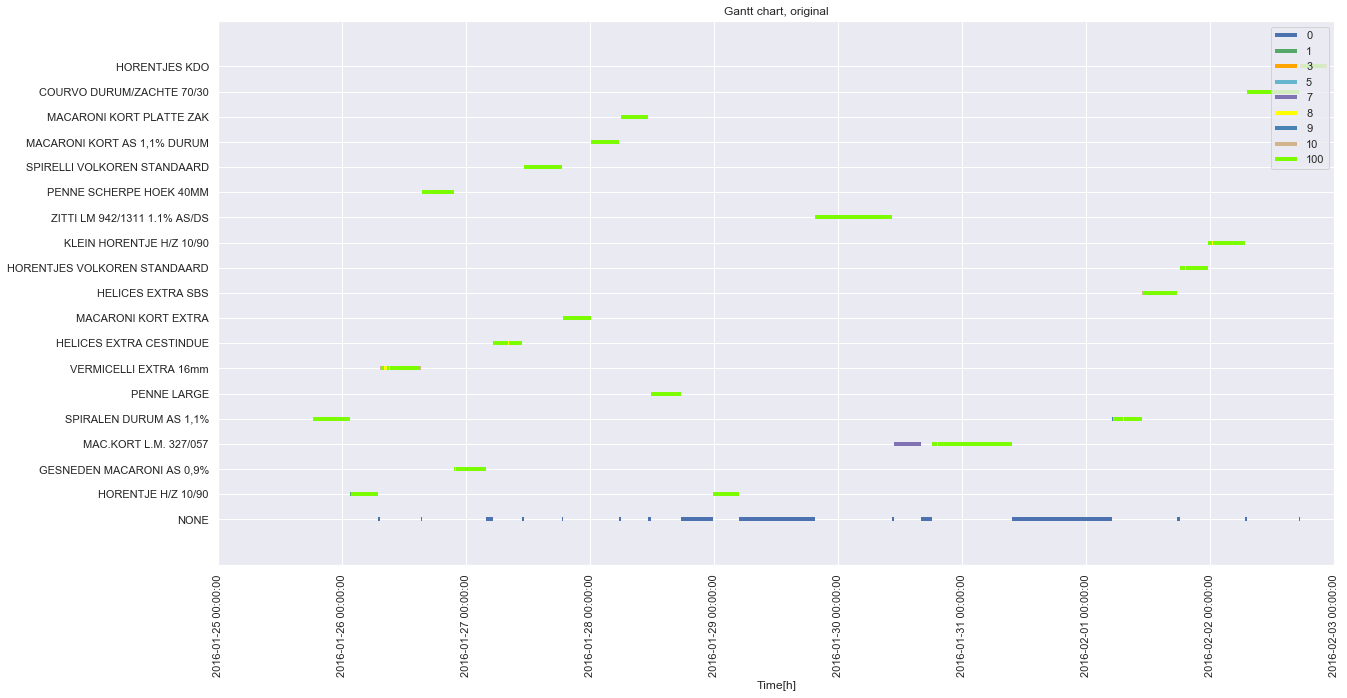

In [10]:
plt.figure(figsize=(20, 10))
# df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
# df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
plot_gantt(df_task, 'ReasonId', 'ArticleName')
plt.title('Gantt chart, original')
plt.savefig('D:/temp/gantt.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [12]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    group_uptime = df_task[df_task.ReasonId == 100].groupby('ProductionRequestId').agg({'Duration':'sum'}) / 60 / 60
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'}) / 60 / 60
    group = pd.concat([group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.Duration = group.Duration
    group.index = group.index.astype(int)
    return group

def simplify_productions(group):
    df = group.copy()
    df['Duration'] = df['Duration'].apply(np.round).astype(int)
    i = 0
    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
        if i == 0:
            df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round('H')
            df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(df.loc[j, 'Duration'], unit='h')
            i += 1
        df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
        df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(df.loc[k, 'Duration'], unit='h')
    df = df[df['Duration'] > 0]
    return df

def save_durations(group, output):
    out = group.copy()
    out.columns = ['Duration', 'Start', 'End', 'Product']
    for col in ['Start', 'End']:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.insert(3, 'Quantity', 20)
    out.index.name = 'ID'
    out.to_csv(output)

group = group_productions(df_task)


In [13]:
group

,Duration,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,
50703,7.286944,2016-01-25 18:16:20.717,2016-01-26 01:33:33.140,"SPIRALEN DURUM AS 1,1%"
-1,0.001307,2016-01-26 01:33:33.140,2016-01-26 01:33:37.847,NONE
50741,5.356389,2016-01-26 01:33:37.847,2016-01-26 06:55:00.217,HORENTJE H/Z 10/90
-2,0.452756,2016-01-26 06:55:00.217,2016-01-26 07:22:10.140,NONE
50912,7.845000,2016-01-26 07:22:10.140,2016-01-26 15:12:52.960,VERMICELLI EXTRA 16mm
-3,0.218627,2016-01-26 15:12:52.960,2016-01-26 15:26:00.017,NONE
50913,6.160000,2016-01-26 15:26:00.017,2016-01-26 21:35:36.180,PENNE SCHERPE HOEK 40MM
-4,0.001386,2016-01-26 21:35:36.180,2016-01-26 21:35:41.170,NONE
50877,6.160000,2016-01-26 21:35:41.170,2016-01-27 03:45:17.303,"GESNEDEN MACARONI AS 0,9%"


In [14]:
group = simplify_productions(group)
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'))
reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
group['ReasonId'] = reasonlist
group.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,
50703,7,2016-01-25 18:00:00,2016-01-26 01:00:00,"SPIRALEN DURUM AS 1,1%",100
50741,5,2016-01-26 01:00:00,2016-01-26 06:00:00,HORENTJE H/Z 10/90,100
50912,8,2016-01-26 06:00:00,2016-01-26 14:00:00,VERMICELLI EXTRA 16mm,100
50913,6,2016-01-26 14:00:00,2016-01-26 20:00:00,PENNE SCHERPE HOEK 40MM,100
50877,6,2016-01-26 20:00:00,2016-01-27 02:00:00,"GESNEDEN MACARONI AS 0,9%",100


In [15]:
def energy_per_production(group):
    articlenum = len(group.ArticleName.unique())
    rand = np.random.random_sample((articlenum,)) * 2 + 10
    energycons = pd.concat([pd.Series(group.ArticleName.unique()), pd.Series(rand)], axis=1)
    energycons.columns = ['Product', 'Power']
    energycons.insert(1, 'UnitPrice', 5)
    energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    return energycons

energycons = energy_per_production(group)
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [16]:
energycons.head()

,Product,UnitPrice,Power,TargetProductionRate
0,"SPIRALEN DURUM AS 1,1%",5,11.435420,3000
1,HORENTJE H/Z 10/90,5,10.918782,3000
2,VERMICELLI EXTRA 16mm,5,11.600991,3000
3,PENNE SCHERPE HOEK 40MM,5,10.399048,3000
4,"GESNEDEN MACARONI AS 0,9%",5,10.301693,3000


In [17]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [18]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [19]:
# def calculate_people_cost(base_price, hours, multipliers, group):
#     people_df = pd.DataFrame([])
#     for h, m in zip(hours, multipliers):
#         starttime = h[0]; endtime = h[1]
        
        

In [20]:
group.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,
50703,7,2016-01-25 18:00:00,2016-01-26 01:00:00,"SPIRALEN DURUM AS 1,1%",100
50741,5,2016-01-26 01:00:00,2016-01-26 06:00:00,HORENTJE H/Z 10/90,100
50912,8,2016-01-26 06:00:00,2016-01-26 14:00:00,VERMICELLI EXTRA 16mm,100
50913,6,2016-01-26 14:00:00,2016-01-26 20:00:00,PENNE SCHERPE HOEK 40MM,100
50877,6,2016-01-26 20:00:00,2016-01-27 02:00:00,"GESNEDEN MACARONI AS 0,9%",100


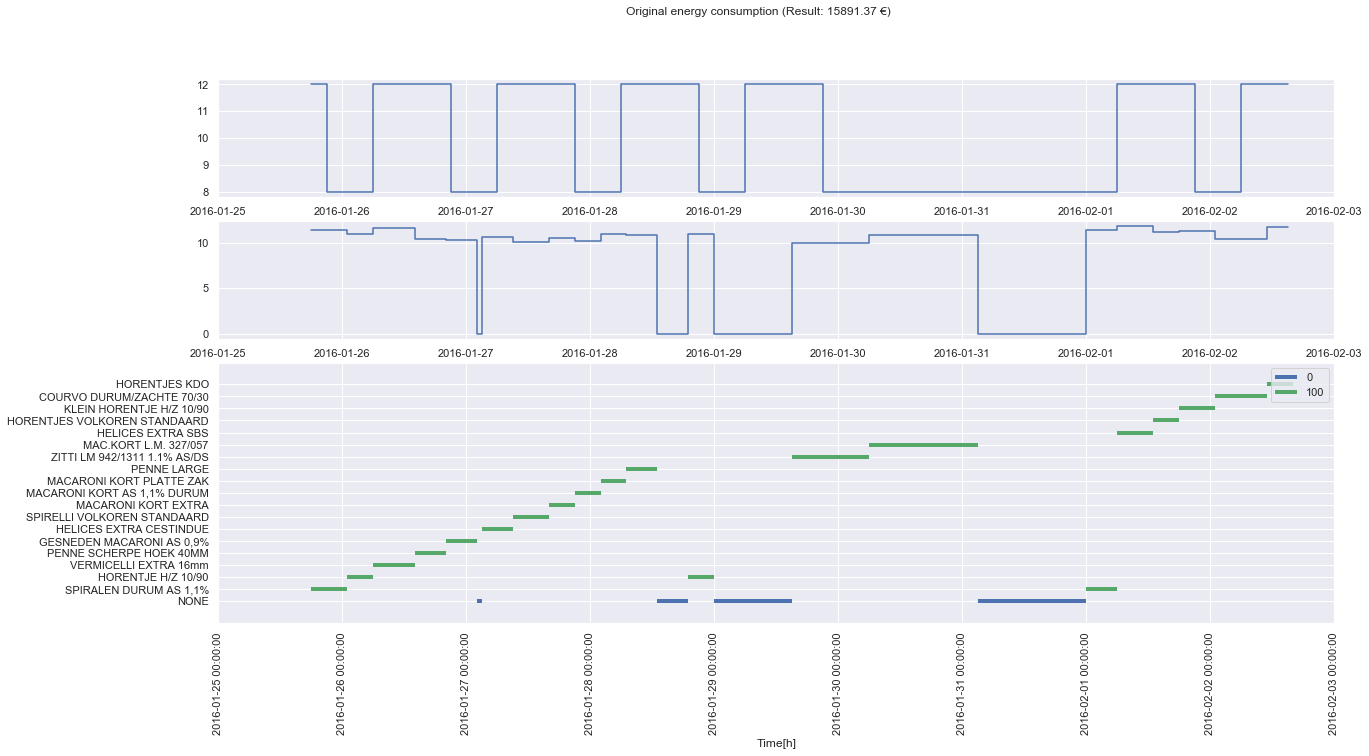

In [21]:
plt.figure(figsize=(20, 10))
c, table = calculate_energy_cost(group, prices, energycons, True)

plt.subplot(4,1,(3,4))
timerange = plot_gantt(group, 'ReasonId', 'ArticleName')

plt.subplot(4,1,1)
plt.suptitle('Original energy consumption (Result: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(4,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
plt.show()

In [22]:
def reorder_schedule(id_list, schedule):
    startdate = schedule.iloc[0]['StartDateUTC']
    df = schedule.loc[id_list]
    #print(df)
    for row in df.T:
        #print(df.loc[row])
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Duration'], unit='h')
        df.loc[row, 'EndDateUTC'] = enddate
        #print(df.loc[row])
        startdate = enddate
    return df

In [23]:
start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
start_time

Timestamp('2016-01-25 18:00:00')

In [32]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
cand_sched, best_result_list, worst_result_list, result_dict_origin, result_dict = run_opt(start_time, end_time, 
       [], [],
        *files, 
        1, 2000, 0.6, 0.8, 8)

Unexpected error when reading down duration information from '[]'
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
29

D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:888: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  warnings.warn('Import of downtime durations failed, using scheduling without failure information.')


Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genet

Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genet

Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genet

Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genet

Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genet

Distance too small, start genetic operation again!544707995334
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small,

Distance too small, start genetic operation again!95334
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start 

Distance too small, start genetic operation again!544707995334
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small, start genetic operation again!
Distance too small,

In [33]:
group_opt = reorder_schedule(cand_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName,ReasonId,Start,End
ProductionRequestId,,,,,,,
51215,7,2016-01-25 18:00:00,2016-01-26 01:00:00,HELICES EXTRA SBS,100,174.0,181.0
-30,2,2016-01-26 01:00:00,2016-01-26 03:00:00,NONE,0,157.0,159.0
-17,2,2016-01-26 03:00:00,2016-01-26 05:00:00,NONE,0,100.0,102.0
50912,8,2016-01-26 05:00:00,2016-01-26 13:00:00,VERMICELLI EXTRA 16mm,100,30.0,38.0
-13,2,2016-01-26 13:00:00,2016-01-26 15:00:00,NONE,0,89.0,91.0


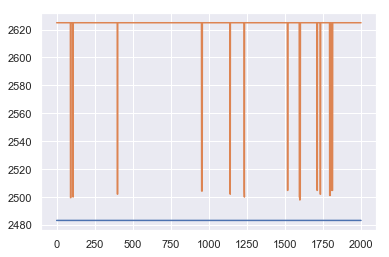

In [34]:
plt.plot(best_result_list)
plt.plot(worst_result_list)

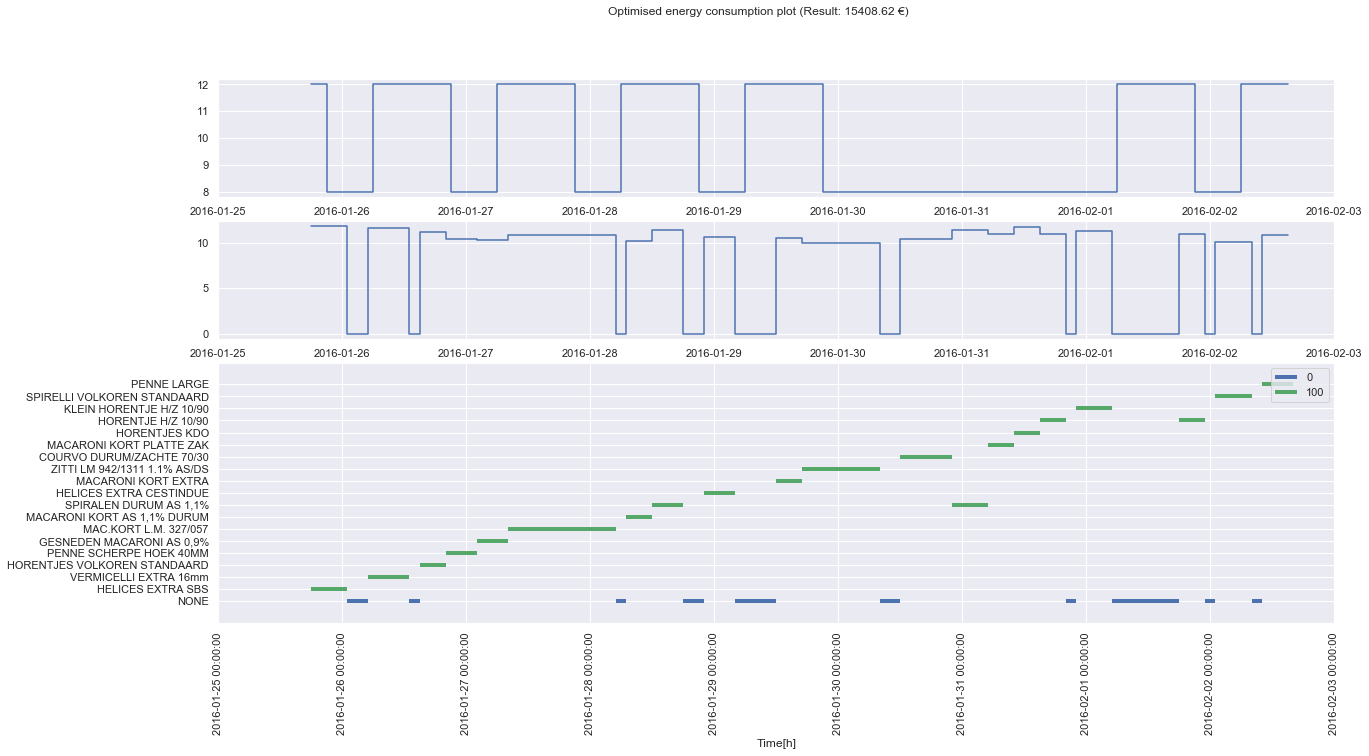

In [35]:
plt.figure(figsize=(20, 10))
c, table = calculate_energy_cost(group_opt, prices, energycons, True)

plt.subplot(4,1,(3,4))
timerange = plot_gantt(group_opt, 'ReasonId', 'ArticleName')

plt.subplot(4,1,1)
plt.suptitle('Optimised energy consumption plot (Result: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(4,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')

In [412]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [413]:
# df_task.Resource.unique()

In [414]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [415]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours